In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import random
from tensorflow.keras import layers
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [61]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\marzi\Desktop\TESI


In [62]:
base_dir = "C://Users//marzi//Documents//LAG_dataset"
print(base_dir)

C://Users//marzi//Documents//LAG_dataset


In [63]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = current_dir + "//data//LAG"
train_dir = data_dir + "//train"
test_dir = data_dir + "//test" 
val_dir = data_dir + "//val"

# Definisci la proporzione di suddivisione (es: 0.8 per l'80% nel train e il 20% nel test)
train_ratio = 0.8 

# Crea le cartelle train e test se non esistono 
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True) 
os.makedirs(test_dir, exist_ok=True) 
os.makedirs(val_dir, exist_ok=True)

# Per ogni classe nella cartella dataset 
for class_name in os.listdir(base_dir): 
    class_path = os.path.join(base_dir, class_name) 
    if os.path.isdir(class_path): 
        # Crea le sottocartelle per ogni classe nelle cartelle train e test 
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True) 
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True) 
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        # Ottieni la lista delle immagini 
        images = os.listdir(class_path) 
        # Dividi in train e test 
        train_images, test_images = train_test_split(images, train_size=train_ratio, random_state=42) 
        # Sposta le immagini nella rispettiva cartella 
        for image in train_images: 
            shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image)) 
        for image in test_images: 
            shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image)) 
print("Divisione completata!")

Divisione completata!


In [64]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
datagen_train = ImageDataGenerator(preprocessing_function=preprocess_input,
shear_range = 0.1,
zoom_range = 0.1,
rotation_range = 20,
width_shift_range = 0.1,
height_shift_range = 0.1,
horizontal_flip = False,
vertical_flip = False,
fill_mode='nearest')

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = datagen_train.flow_from_directory(
    'data//LAG//train',
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'data//LAG//test',
    class_mode='categorical',
    shuffle=False)

Found 3882 images belonging to 2 classes.
Found 972 images belonging to 2 classes.


In [65]:
print(train_ds.samples)

3882


In [66]:
# bilanciamento del dataset
from sklearn.utils import class_weight
import numpy as np

# Calcola i pesi delle classi
labels = train_ds.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].


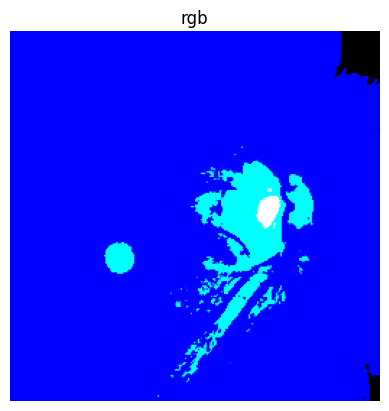

In [67]:
# Retrieve a batch of images and labels
images, labels = next(train_ds)

# Display the first image in the batch
plt.imshow(images[0])
plt.title('rgb')
plt.axis('off')  # Turn off axis
plt.show()

In [68]:
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Flatten
# from keras.layers import Dense,Dropout
# from keras.layers import BatchNormalization

# # Initialising the CNN
# classifier = Sequential()
# # Step 1 - Adding Convolution layer
# classifier.add(Conv2D(32, (3, 3), input_shape = (256,256, 3), activation = 'relu'))

# # Step 2 - Adding MaxPooling layers
# classifier.add(MaxPooling2D(pool_size = (2, 2)))
# # Adding a second convolutional layer
# classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
# classifier.add(MaxPooling2D(pool_size = (2, 2)))

# # Step 3 - Flattening
# classifier.add(Flatten())

# # Step 4 - Full connection
# classifier.add(Dense(units = 512, activation = 'relu'))
# classifier.add(BatchNormalization()),
# classifier.add(Dense(256,activation='relu')),
# classifier.add(Dropout(0.25)),
# classifier.add(Dense(units = 2, activation = 'softmax'))

# # Compiling the CNN
# classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [69]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import silu

# Carica il modello VGG16 pre-addestrato senza i livelli fully connected alla fine
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

model = Sequential()

# Congela i pesi del modello base
for layer in base_model.layers:
    layer.trainable = False

model.add(base_model)

# # Aggiungi i tuoi livelli fully connected alla fine del modello base
# model.add(Flatten())
# model.add(Dense(256, activation=silu))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(2, activation='softmax'))  # 1 neurone di output con attivazione sigmoid per 2 classi

# Full connection
model.add(Flatten())
model.add(Dense(units = 1028, activation = 'relu'))
model.add(BatchNormalization()),
model.add(Dense(512,activation='relu')),
model.add(Dropout(0.25)),
model.add(Dense(units = 2, activation = 'softmax'))

# Compila il modello
learning_rate = 0.00001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Definizione della callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',  # Monitora la loss sul set di validazione
                               patience=5,          # Numero di epoche senza miglioramenti prima di fermarsi
                               restore_best_weights=True)  # Ripristina i pesi del miglior modello

# Definizione della callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la loss sul set di validazione
                              factor=0.2,          # Fattore di riduzione del tasso di apprendimento
                              patience=3,          # Numero di epoche senza miglioramenti prima di ridurre il tasso
                              min_lr=1e-5)         # Limite inferiore per il tasso di apprendimento

initial_epochs = 25

# Train the model
model_info = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=test_ds,
    class_weight=class_weights,
)

Epoch 1/25


c:\Users\marzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 388s 3s/step - accuracy: 0.5403 - loss: 0.8874 - val_accuracy: 0.6111 - val_loss: 0.7205
Epoch 2/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.6329 - loss: 0.7265 - val_accuracy: 0.6512 - val_loss: 0.6221
Epoch 3/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.7128 - loss: 0.5695 - val_accuracy: 0.6934 - val_loss: 0.5592
Epoch 4/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - accuracy: 0.8128 - loss: 0.4193 - val_accuracy: 0.7088 - val_loss: 0.5311
Epoch 5/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.8781 - loss: 0.3344 - val_accuracy: 0.7171 - val_loss: 0.5095
Epoch 6/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.9034 - loss: 0.2728 - val_accuracy: 0.7263 - val_loss: 0.4960
Epoch 7/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.9372 - loss: 0.2002 - val_accuracy: 0.7356 - val_loss: 0.4857
Epoch 8/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.9481 - loss: 0.1927 - val_accuracy: 0.749

In [71]:
# model.save('my_model.h5')

In [72]:
print(model_info.history['accuracy'])

[0.5682637691497803, 0.6555898785591125, 0.7418856024742126, 0.8183925747871399, 0.882019579410553, 0.9052035212516785, 0.9312210083007812, 0.9471921920776367, 0.9562081694602966, 0.9629057049751282, 0.9662545323371887, 0.9706336855888367, 0.9783616662025452, 0.9866048693656921, 0.9863472580909729, 0.9884080290794373, 0.9914992451667786, 0.9876352548599243, 0.9907264113426208, 0.9922720193862915, 0.9907264113426208, 0.9935600161552429, 0.9953632354736328, 0.9956207871437073, 0.996393620967865]


In [73]:
print(model_info.history['val_accuracy'])

[0.6111111044883728, 0.6512345671653748, 0.693415641784668, 0.7088477611541748, 0.7170782089233398, 0.7263374328613281, 0.7355967164039612, 0.748971164226532, 0.7705761194229126, 0.7664608955383301, 0.7808641791343689, 0.7788065671920776, 0.797325074672699, 0.798353910446167, 0.7829217910766602, 0.8004115223884583, 0.8014403581619263, 0.797325074672699, 0.8106995820999146, 0.8189300298690796, 0.7921810746192932, 0.8220164775848389, 0.8055555820465088, 0.8076131939888, 0.806584358215332]


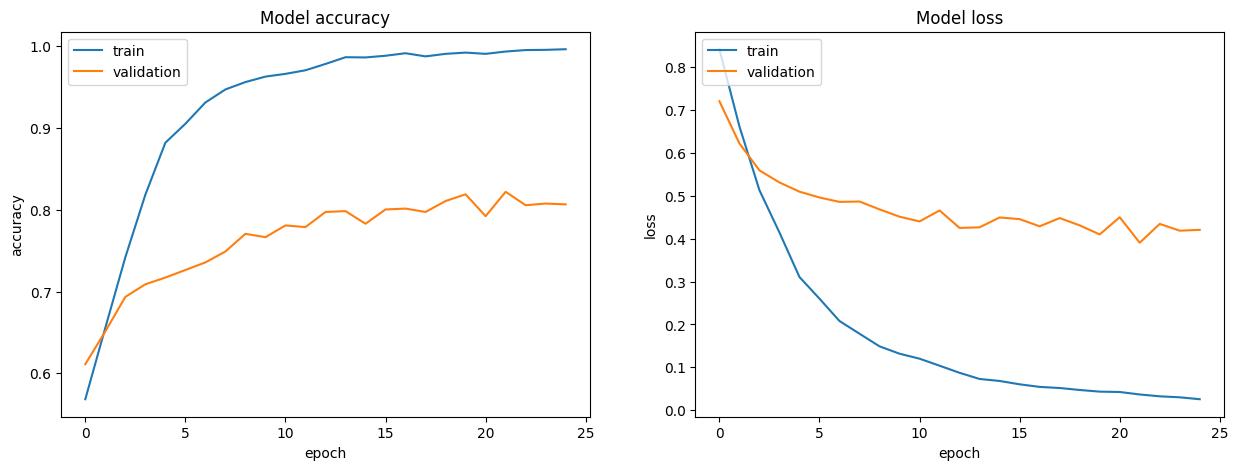

In [74]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(model_info)

In [75]:
# Scongela alcuni dei livelli convoluzionali del modello base per fare fine-tuning
for layer in base_model.layers[-4:]:  # Scongela gli ultimi 4 livelli convoluzionali
    layer.trainable = True

# Ricompila il modello con un learning rate più basso
model.compile(optimizer=RMSprop(learning_rate=1e-7), loss='categorical_crossentropy', metrics=['accuracy'])

# Continua l'addestramento con fine-tuning
fine_tuning_epochs = 15
total_epochs = initial_epochs + fine_tuning_epochs

fine_tuning_info = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=model_info.epoch[-1],  # Inizia dal punto in cui l'addestramento precedente si è fermato
    validation_data=test_ds,
    class_weight=class_weights,
)

Epoch 25/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.9954 - loss: 0.0234 - val_accuracy: 0.8056 - val_loss: 0.4158
Epoch 26/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.9956 - loss: 0.0247 - val_accuracy: 0.8066 - val_loss: 0.4167
Epoch 27/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.9970 - loss: 0.0228 - val_accuracy: 0.8097 - val_loss: 0.4121
Epoch 28/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.9966 - loss: 0.0248 - val_accuracy: 0.8035 - val_loss: 0.4201
Epoch 29/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.9985 - loss: 0.0218 - val_accuracy: 0.8025 - val_loss: 0.4225
Epoch 30/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.9973 - loss: 0.0211 - val_accuracy: 0.8117 - val_loss: 0.4058
Epoch 31/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 16457s 136s/step - accuracy: 0.9973 - loss: 0.0227 - val_accuracy: 0.8014 - val_loss: 0.4193
Epoch 32/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.9954 - loss: 0.025

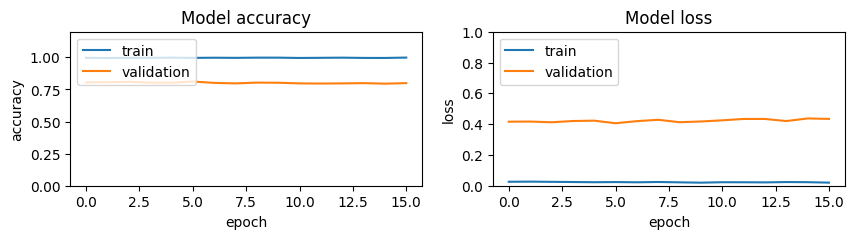

In [76]:
def plot_train_history(history):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0, 1.2)  # Limiti dell'asse y tra 0 e 1
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.ylim(0, 1)
    plt.show()
plot_train_history(fine_tuning_info)

In [77]:
# model=load_model(classifier)
# print("Glaucoma detection model loaded")

In [78]:
def glaucoma_prediction(test_image):
  image = img_to_array(test_image)
  image = np.expand_dims(image, axis = 0)
  result = np.argmax(model.predict(image))
  return result

In [79]:
# glaucoma img
test_image = load_img(origa + '/036.jpg', target_size = (256,256))
prediction = glaucoma_prediction(test_image)
if prediction == 0:
 print("Glaucoma")
else:
 print("Not Glaucoma")

NameError: name 'origa' is not defined

In [ ]:
# not glaucoma img
test_image = load_img(origa + '/642.jpg', target_size = (256,256))
prediction = glaucoma_prediction(test_image)
if prediction == 0:
 print("Glaucoma")
else:
 print("Not Glaucoma")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Glaucoma


In [ ]:
# evaluate model accuracy
score=model.evaluate(test_ds)
print("Loss:",score[0],"Accuracy:",score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5511 - loss: 0.8459
Loss: 0.7952587008476257 Accuracy: 0.5757575631141663


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sb

In [ ]:
pred= np.round(model.predict(test_ds, verbose=1))
test_labels=test_ds.labels
test_pred_labels=[]
for i in range(len(pred)):
  test_pred_labels.append(np.argmax(pred[i]))
conf_matrix= confusion_matrix(test_pred_labels,test_labels)
print (conf_matrix)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
[[10 26]
 [16 47]]


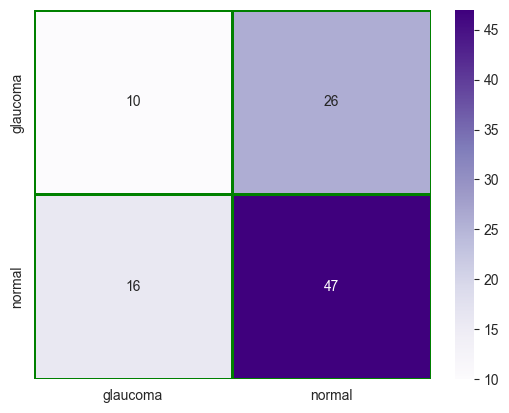

In [ ]:
sb.heatmap(conf_matrix,cmap='Purples', annot=True,xticklabels=['glaucoma','normal'],yticklabels=['glaucoma','normal'],linewidths=1,
                linecolor='green').plot()
plt.show()


In [ ]:
test_report = classification_report(test_ds.labels,test_pred_labels, target_names=['glaucoma','normal'], output_dict=True)
test_df = pd.DataFrame(test_report).transpose()
test_df

,precision,recall,f1-score,support
glaucoma,0.277778,0.384615,0.322581,26.000000
normal,0.746032,0.643836,0.691176,73.000000
accuracy,0.575758,0.575758,0.575758,0.575758
macro avg,0.511905,0.514226,0.506879,99.000000
weighted avg,0.623056,0.575758,0.594374,99.000000
